In [1]:

import argparse
import os
import random
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.pyplot import imshow, imsave

# Set random seem for reproducibility
manualSeed = 1312
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

print(torchvision.__version__)

Random Seed:  1312
0.2.1


In [2]:
# This cell is only for Google Colaboratory
#from google.colab import drive
#drive.mount('/content/gdrive')
#
path1 = "train_images" # Fake generated images here
path2 = "gen"   # Generator parameters path
path3 = "dis"   # Discriminator parameters path

In [3]:
# Root directory for dataset
dataroot = "Art/Uusi_Kansio"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 100

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3 # with mnist 1, other 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
max_epoch = 100 # need more than 20 epochs for training generator

# Learning rate for optimizers
lr = 0.0005

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Number of labels
num_labels = 4 # we will use 4, CIFAR and MNIST has 10

In [4]:
# Define which device you use for calculation. If you can use cuda, this will automatically use it. Otherwise cpu is automatically used.

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [5]:

#transform=torchvision.transforms.Compose([
 #                                torchvision.transforms.Resize(image_size),
  #                               torchvision.transforms.ToTensor(),
   #                              torchvision.transforms.Normalize(
    #                             (0.5,0.5,0.5), (0.5,0.5,0.5))])

#dataset =  torchvision.datasets.CIFAR10('/files/', train=True, download=True, transform = transform)

#data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

#real_batch = next(iter(data_loader))
#plt.figure(figsize=(8,8))
#plt.axis("off")
#plt.title("Training Images")
#plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [86]:
dataroot = []
dataset = []
# Create new dataset from images
for i in range(1,num_labels + 1):
    dataset.append(dset.ImageFolder(root=F"./Dog_images/Label{i}",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])))

# Create labels for our dataset
# Labels are in i
for i in range(len(dataset)):
    for j in range(len(dataset[i])):
        dataset[i].samples[j] = (dataset[i].samples[j][0],i)
        
# Combine all the datasets
newdataset = torch.utils.data.ConcatDataset(dataset)

50200


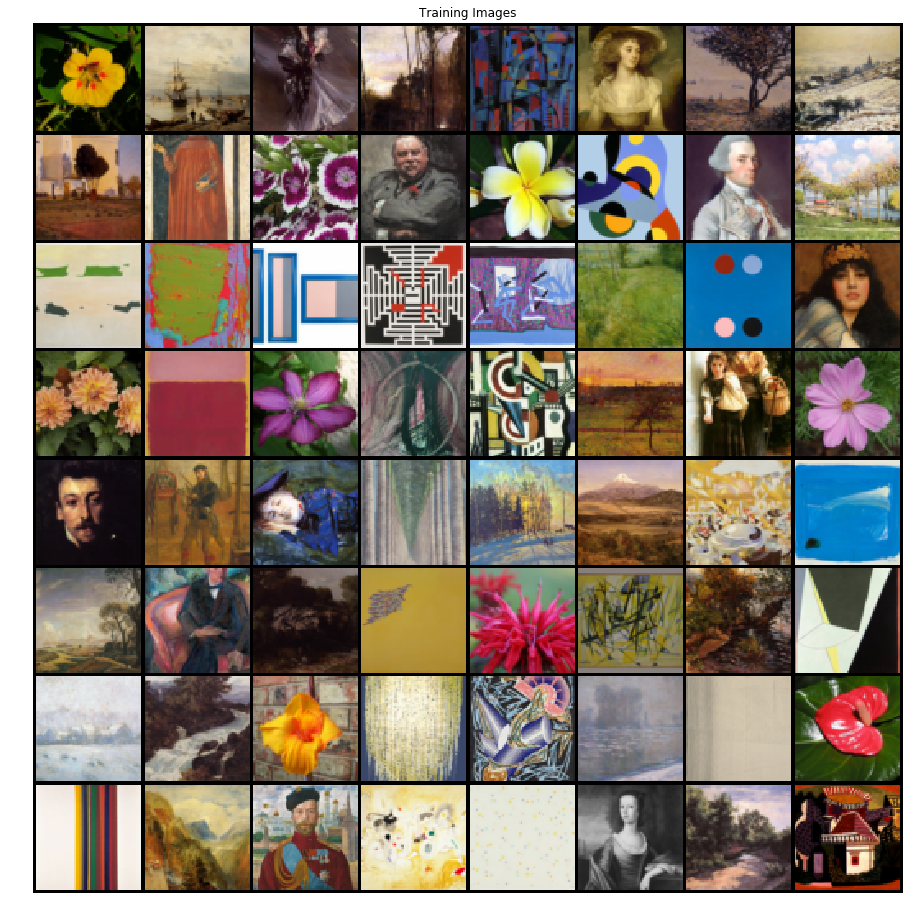

In [87]:
dataloader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                        shuffle=True, num_workers=workers)

# Decide which device we want to run on
#DEVICE = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch,labels = next(iter(dataloader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(DEVICE), padding=2, nrow = 10, normalize=True).cpu(),(1,2,0)))

print(len(dataloader.dataset))

In [88]:
def normal_init(m, mean=0., std=0.02):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        #m.bias.data.zero_()
print(len(dataloader.dataset))        

50200


In [89]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
        MUUTTUJAT PÄIN VITTUA, KORJATKAA GLOBAALISTA LOKAAlIKSI
    """
    def __init__(self, in_channel=1, input_size=784, condition_size=10):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(nc, ndf,4,2,1,bias=False)
        
        # first parameter is number of classes, condition_size is the same as number of classes
        self.convlabel = nn.Conv2d(condition_size, ndf,4,2,1,bias=False)
        self.conv2 = nn.Conv2d(ndf * 2,ndf * 4, 4, 2, 1, bias = False)
        self.bn1 = nn.BatchNorm2d(ndf * 4)
        self.conv3 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 8)
        self.conv4 = nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 16)
        self.conv5 = nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False)

        self.act = nn.LeakyReLU(0.2,inplace=True)
        self.out = nn.Sigmoid()
        self.weight_init(mean = 0., std = 0.02)
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    
    def forward(self, x, y=None):
        
        x = self.act(self.conv1(x))
        y = self.act(self.convlabel(y))
        x = torch.cat([x,y],1)
        x = self.act(self.bn1(self.conv2(x)))
        x = self.act(self.bn2(self.conv3(x)))
        x = self.act(self.bn3(self.conv4(x)))
        x = self.conv5(x)
        return self.out(x)

In [5]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size = 100, condition_size=10):
        super(Generator, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(input_size, ngf * 8, 4, 1, 0,bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*8)
        
        
        # first parameter is number of classes
        self.convlabel = nn.ConvTranspose2d(condition_size, ngf * 8, 4, 1, 0,bias=False)
        self.bn1_1 = nn.BatchNorm2d(ngf * 8)
        
        self.act = nn.LeakyReLU(0.2,inplace=True)
        
        self.conv2 = nn.ConvTranspose2d(ngf * 16,ngf * 8, 4, 2, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(ngf * 8)

        self.conv3 = nn.ConvTranspose2d(ngf * 8,ngf * 4, 4, 2, 1, bias = False)
        self.bn3 = nn.BatchNorm2d(ngf * 4)
        
        self.conv4 = nn.ConvTranspose2d(ngf * 4,ngf * 2, 4, 2, 1, bias = False)
        self.bn4 = nn.BatchNorm2d(ngf * 2)
        
        self.conv5 = nn.ConvTranspose2d(ngf*2, nc, 4, 2, 1, bias = False)
        self.out = nn.Tanh()
        self.weight_init(mean = 0., std = 0.02)
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x, y):
        
        x = self.act(self.bn1(self.conv1(x)))
        y = self.act(self.bn1_1(self.convlabel(y)))
        x = torch.cat([x,y],1)
        x = self.act(self.bn2(self.conv2(x)))
        x = self.act(self.bn3(self.conv3(x)))
        x = self.act(self.bn4(self.conv4(x)))
        x = self.conv5(x)
        
        return self.out(x)

In [91]:
D = Discriminator(condition_size = num_labels).to(DEVICE)
G = Generator(condition_size=num_labels).to(DEVICE)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

# Initialize discriminator and Generator weights
#D.apply(weight_init)
#G.apply(weight_init)


# Setup Adam optimizers for both G and D
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

print(ngf*8)

512


In [92]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn((batch_size, 100, 1, 1))
fixed_noise = Variable(fixed_noise.to(DEVICE))




In [93]:
# Initialize stuff before training
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [94]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

smooth1 = torch.cuda.FloatTensor(np.random.uniform(-0.1,0.1,batch_size))
smooth2 = torch.cuda.FloatTensor(np.random.uniform(0.,0.2,batch_size))

label = torch.full((batch_size,), D_labels, device=DEVICE)
D_labels = label.add(smooth1)

label = torch.full((batch_size,), D_fakes, device=DEVICE)
D_fakes = label.add(smooth2)

[0/100][0]	Loss_D: 1.6926	Loss_G: 15.0028	D(x): 0.7500	D(G(z)): 0.7348 / 0.0000
[0/100][20]	Loss_D: 0.9426	Loss_G: 1.2272	D(x): 0.9106	D(G(z)): 0.4970 / 0.3537
[0/100][40]	Loss_D: 2.5460	Loss_G: 6.1986	D(x): 0.1447	D(G(z)): 0.0015 / 0.0053
[0/100][60]	Loss_D: 1.1687	Loss_G: 7.1089	D(x): 0.9390	D(G(z)): 0.6325 / 0.0025
[0/100][80]	Loss_D: 1.5495	Loss_G: 3.9152	D(x): 0.7161	D(G(z)): 0.5884 / 0.0488
[0/100][100]	Loss_D: 1.2738	Loss_G: 1.9778	D(x): 0.3933	D(G(z)): 0.1026 / 0.2300
[0/100][120]	Loss_D: 0.9667	Loss_G: 2.9917	D(x): 0.7840	D(G(z)): 0.3644 / 0.0999
[0/100][140]	Loss_D: 1.3564	Loss_G: 1.0469	D(x): 0.3090	D(G(z)): 0.0346 / 0.4215
[0/100][160]	Loss_D: 0.4712	Loss_G: 2.6239	D(x): 0.6890	D(G(z)): 0.0434 / 0.0983
[0/100][180]	Loss_D: 0.6172	Loss_G: 1.2301	D(x): 0.8550	D(G(z)): 0.3386 / 0.3445
[0/100][200]	Loss_D: 1.4706	Loss_G: 2.4762	D(x): 0.9089	D(G(z)): 0.7049 / 0.1026
[0/100][220]	Loss_D: 0.5981	Loss_G: 0.3293	D(x): 0.8418	D(G(z)): 0.3194 / 0.7309
[0/100][240]	Loss_D: 1.1417	Loss_

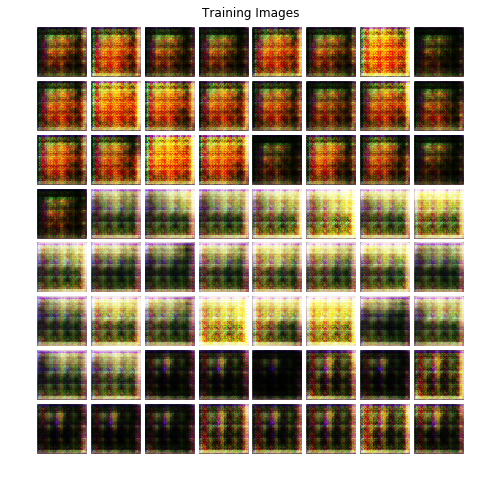

[1/100][520]	Loss_D: 0.3219	Loss_G: 3.8657	D(x): 0.8599	D(G(z)): 0.1517 / 0.0246
[1/100][540]	Loss_D: 0.7391	Loss_G: 2.7071	D(x): 0.9930	D(G(z)): 0.5165 / 0.0690
[1/100][560]	Loss_D: 0.7521	Loss_G: 1.0824	D(x): 0.9361	D(G(z)): 0.4740 / 0.3570
[1/100][580]	Loss_D: 0.5185	Loss_G: 0.3221	D(x): 0.6265	D(G(z)): 0.0472 / 0.7283
[1/100][600]	Loss_D: 0.3253	Loss_G: 0.7814	D(x): 0.8669	D(G(z)): 0.1595 / 0.4871
[1/100][620]	Loss_D: 1.9415	Loss_G: 0.7586	D(x): 0.1498	D(G(z)): 0.0178 / 0.4948
[1/100][640]	Loss_D: 0.9274	Loss_G: 2.0653	D(x): 0.9769	D(G(z)): 0.5845 / 0.1531
[1/100][660]	Loss_D: 0.2952	Loss_G: 1.2415	D(x): 0.9868	D(G(z)): 0.2381 / 0.3961
[1/100][680]	Loss_D: 0.3779	Loss_G: 5.4959	D(x): 0.9281	D(G(z)): 0.2525 / 0.0047
[1/100][700]	Loss_D: 0.2220	Loss_G: 6.3808	D(x): 0.8355	D(G(z)): 0.0259 / 0.0019
[1/100][720]	Loss_D: 0.8030	Loss_G: 0.3288	D(x): 0.5074	D(G(z)): 0.0931 / 0.7218
[1/100][740]	Loss_D: 1.5814	Loss_G: 0.9194	D(x): 0.2566	D(G(z)): 0.0714 / 0.4111
[1/100][760]	Loss_D: 0.1106	

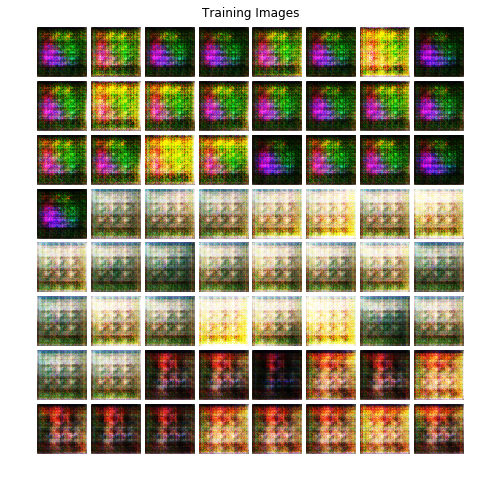

[2/100][1020]	Loss_D: 0.2372	Loss_G: 2.9973	D(x): 0.8242	D(G(z)): 0.0211 / 0.0522
[2/100][1040]	Loss_D: 2.2138	Loss_G: 0.2453	D(x): 0.1350	D(G(z)): 0.0058 / 0.7855
[2/100][1060]	Loss_D: 0.0439	Loss_G: 5.2238	D(x): 0.9621	D(G(z)): 0.0050 / 0.0119
[2/100][1080]	Loss_D: 0.0167	Loss_G: 0.1092	D(x): 0.9993	D(G(z)): 0.0159 / 0.8970
[2/100][1100]	Loss_D: 4.3394	Loss_G: 2.3078	D(x): 0.0137	D(G(z)): 0.0156 / 0.1353
[2/100][1120]	Loss_D: 1.0773	Loss_G: 0.5714	D(x): 0.8399	D(G(z)): 0.5923 / 0.5670
[2/100][1140]	Loss_D: 0.3723	Loss_G: 7.3427	D(x): 0.8940	D(G(z)): 0.2014 / 0.0017
[2/100][1160]	Loss_D: 0.7353	Loss_G: 3.5156	D(x): 0.8601	D(G(z)): 0.4404 / 0.0307
[2/100][1180]	Loss_D: 0.0549	Loss_G: 2.5638	D(x): 0.9783	D(G(z)): 0.0324 / 0.0828
[2/100][1200]	Loss_D: 1.4005	Loss_G: 4.2259	D(x): 0.8048	D(G(z)): 0.6515 / 0.0187
[2/100][1220]	Loss_D: 0.7115	Loss_G: 1.1954	D(x): 0.5182	D(G(z)): 0.0503 / 0.3067
[2/100][1240]	Loss_D: 1.1465	Loss_G: 1.9892	D(x): 0.8413	D(G(z)): 0.5640 / 0.2040
[2/100][1260]	Lo

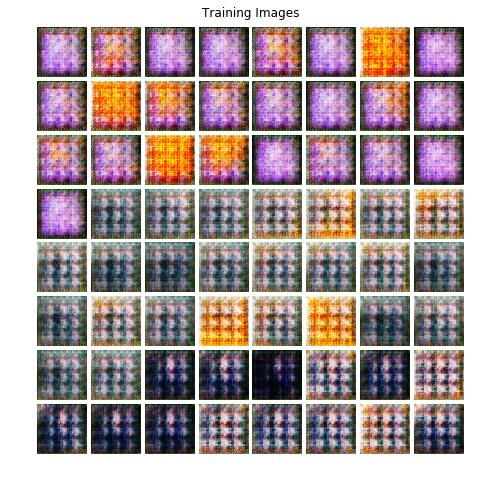

[3/100][1520]	Loss_D: 1.4099	Loss_G: 5.1016	D(x): 0.2766	D(G(z)): 0.0216 / 0.0091
[3/100][1540]	Loss_D: 0.1338	Loss_G: 1.7315	D(x): 0.9301	D(G(z)): 0.0564 / 0.1934
[3/100][1560]	Loss_D: 0.3841	Loss_G: 0.6598	D(x): 0.9521	D(G(z)): 0.2778 / 0.5219
[3/100][1580]	Loss_D: 0.1582	Loss_G: 3.8315	D(x): 0.8554	D(G(z)): 0.0016 / 0.0218
[3/100][1600]	Loss_D: 1.9997	Loss_G: 1.7190	D(x): 0.1519	D(G(z)): 0.0006 / 0.2113
[3/100][1620]	Loss_D: 0.6733	Loss_G: 3.3804	D(x): 0.5801	D(G(z)): 0.0990 / 0.0377
[3/100][1640]	Loss_D: 1.5585	Loss_G: 3.8109	D(x): 0.3664	D(G(z)): 0.3484 / 0.0358
[3/100][1660]	Loss_D: 0.5244	Loss_G: 0.9623	D(x): 0.6071	D(G(z)): 0.0039 / 0.3869
[3/100][1680]	Loss_D: 1.2137	Loss_G: 1.9414	D(x): 0.9982	D(G(z)): 0.6915 / 0.1475
[3/100][1700]	Loss_D: 2.2836	Loss_G: 1.7744	D(x): 0.9179	D(G(z)): 0.8626 / 0.1732
[3/100][1720]	Loss_D: 0.0442	Loss_G: 3.9892	D(x): 0.9706	D(G(z)): 0.0141 / 0.0349
[3/100][1740]	Loss_D: 0.0832	Loss_G: 1.8252	D(x): 0.9452	D(G(z)): 0.0256 / 0.1792
[3/100][1760]	Lo

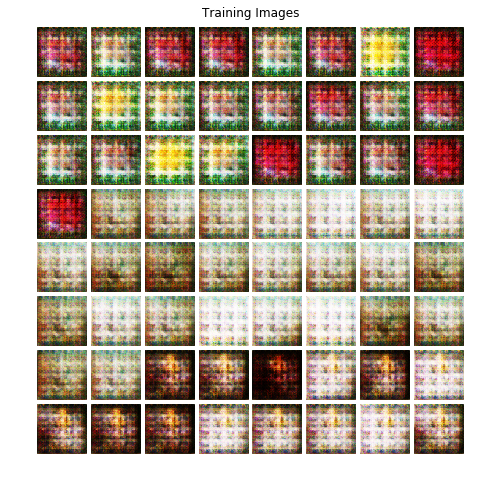

[4/100][2020]	Loss_D: 1.1742	Loss_G: 3.0040	D(x): 0.3471	D(G(z)): 0.0585 / 0.0570
[4/100][2040]	Loss_D: 0.4630	Loss_G: 1.5949	D(x): 0.9795	D(G(z)): 0.3564 / 0.2052
[4/100][2060]	Loss_D: 0.4265	Loss_G: 4.0072	D(x): 0.8284	D(G(z)): 0.2103 / 0.0194
[4/100][2080]	Loss_D: 1.2741	Loss_G: 0.0553	D(x): 0.2831	D(G(z)): 0.0067 / 0.9463
[4/100][2100]	Loss_D: 0.4857	Loss_G: 0.9057	D(x): 0.9617	D(G(z)): 0.3493 / 0.4079


In [ ]:
# Training loop
#from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True

# Create arrays for Generator and Discriminator losses
G_losses = []
D_losses = []
img_list = []

fixed_y = torch.zeros(num_labels, 1)
y_label = torch.zeros(batch_size, num_labels)

# Creates onehot array, that is diagonal matrix in tensor from.
onehot = torch.zeros(num_labels, num_labels)
onehot = onehot.scatter_(1, torch.LongTensor([range(num_labels)]).view(num_labels,1), 1).view(num_labels, num_labels, 1, 1)

# Creates fill that makes image size layer with ones for each label
fill = torch.zeros([num_labels, num_labels, image_size, image_size]).to(DEVICE)
for i in range(num_labels):
    fill[i, i, :, :] = 1



# Fixed Y labels for evaluation
y_0 = torch.full((batch_size//num_labels, 1), 0).type(torch.LongTensor).squeeze()
y_fixed_labels = torch.zeros(batch_size, num_labels)

for i in range(1,num_labels):
    desired_label = i
    y_fixed = torch.full((batch_size//num_labels, 1), desired_label).type(torch.LongTensor).squeeze()

    y_0 = torch.cat((y_0, y_fixed), 0)

y_fixed_labels = onehot[y_0]
y_fixed_labels= Variable(y_fixed_labels.cuda())


for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(dataloader):

        # Training Discriminator
        D.zero_grad()
        # Use print(labels.shape) to check how large batch size should be
        #print(labels.shape)
        
        
        y_fill = fill[labels]
        
        x = images.to(DEVICE)
        y = y_fill
        x_outputs = D(x, y)
        x_outputs = x_outputs.view(-1,1)
        D_x = x_outputs.mean().item() # D(x|c) for real data
        D_x_loss = criterion(x_outputs, D_labels)
        
        # Fake data:
        
        z = torch.randn((batch_size, 100, 1, 1))
        y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
        y_label = onehot[y_rand]
        y_fill = fill[y_rand]
        z = Variable(z.to(DEVICE))
        y_label = Variable(y_label.to(DEVICE))
        y_fill =  Variable(y_fill.to(DEVICE))
        
        fake_images = G(z, y_label)
        
        fake_outputs = D(fake_images, y_fill)
        fake_outputs = fake_outputs.view(-1,1)
        D_g_z1 = fake_outputs.mean().item() # D(G(z|c)|c) for fake data
        D_z_loss = criterion(fake_outputs, D_fakes)
         
        D_loss = D_x_loss + D_z_loss
        
        
        D_loss.backward()
        D_opt.step()
        
        if step % n_critic == 0:
            # Training Generator
            G.zero_grad()
            z = torch.randn((batch_size, 100, 1, 1))
            y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
            y_label = onehot[y_rand]
            y_fill = fill[y_rand]
            z = Variable(z.to(DEVICE))
            y_label = Variable(y_label.to(DEVICE))
            y_fill =  Variable(y_fill.to(DEVICE))
            
            fake_images = G(z,y_label)
            fake_outputs = D(fake_images, y_fill)
            D_g_z2 = fake_outputs.mean().item() # D(G(z|c)|c) for fake data
            fake_outputs = fake_outputs.view(-1,1)
            G_loss = criterion(fake_outputs, D_labels)
            
            
            G_loss.backward()
            G_opt.step()       
        if step % 20 == 0:
            #print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {},  D(x): {}   D(G(z)): {} / {}'.format(epoch, max_epoch, 
            #                                        step, D_loss.item(), G_loss.item(),D_x,D_g_z1,D_g_z2))
            print('[%d/%d][%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, max_epoch, step,
                     D_loss.item(), G_loss.item(), D_x, D_g_z1, D_g_z2))
            
            # Output training stats
        

            # Save Losses for plotting later
            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())
            
        step += 1
        
    if (epoch % 1 == 0):
        print("Figure number: ", epoch+1)
        # generation to image
        G.eval()

        # Create labels from 0 to 9 (tensor is 100 long)
       
        # save image
        
        #torch.save(netG.state_dict(), os.path.join(path2, 'G--{}.ckpt'.format(epoch+1)))
        #torch.save(netD.state_dict(), os.path.join(path3, 'D--{}.ckpt'.format(epoch+1)))
        with torch.no_grad():
            fake_images = G(fixed_noise,y_fixed_labels).detach().cpu()
        
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title("Training Images")
        plt.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE), padding=5,pad_value = 1, nrow = 10, normalize=True).cpu(),(1,2,0)))
        plt.show()

        
        img_list.append(vutils.make_grid(fake_images, padding=2, nrow = 10, normalize=True))
        vutils.save_image((fake_images.data), os.path.join(path1, 'fake_images-{}.png'.format(epoch+1)), nrow = 10, normalize=True)
        
        G.train()   

In [ ]:
# Plot losses

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# generation to image
G.eval()

# put here the desired label you want to be seen
desired_label = 0

y_rand = torch.full((batch_size, 1), desired_label).type(torch.LongTensor).squeeze()
y_label = onehot[y_rand]
#y_label = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(10,1), 1).view(10, 10, 1, 1)
z = Variable(z.cuda())
y_label = Variable(y_label.cuda())


# Generate images using fixed noise and specific labels. For example "generate fake landscape images"
with torch.no_grad():
    fake_images = G(fixed_noise,y_label).detach().cpu()


    

# Plot figures of specific labels    
    
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE)[:64], padding=5,pad_value = 1, normalize=True).cpu(),(1,2,0)))


# Plot each image separately.

#print(fake_images[0][0].shape)
#for i in range(20):
 #   plt.imshow(fake_images[i][0])
  #  plt.show()

In [ ]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [ ]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_dc.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_dc.pth.tar')

AssertionError: Torch not compiled with CUDA enabled